In [1]:
from typing import Any
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
def load_image(image_file_path: str) -> np.ndarray:
    try:
        with Image.open(image_file_path) as img:
            return np.array(img)
    except (FileNotFoundError, OSError) as e:
        print(f"Error opening image: {image_file_path}", e)
        return None

In [4]:
from typing import List, Tuple, Dict

def convert_labels_to_numbers(labels: List[str]) -> Tuple[List[int], Dict[int, str]]:
    distinct_labels = sorted(set(labels))  # Sort to ensure consistent numbering
    label_name_to_number = {label: index for index, label in enumerate(distinct_labels)}
    label_number_to_name = {index: label for label, index in label_name_to_number.items()}
    
    labels_int = [label_name_to_number[label] for label in labels]
    
    return labels_int, label_number_to_name

In [5]:
def augment_image(image: np.ndarray) -> List[np.ndarray]:
    if image is None or image.ndim < 2:
        print(f"Invalid image shape: {image.shape if image is not None else None}")
        return [image] if image is not None else []
    
    augmented = []
    # Original image
    augmented.append(image)
    # Horizontal flip
    augmented.append(np.fliplr(image))
    # Vertical flip
    augmented.append(np.flipud(image))
    return augmented

In [6]:
def load_normalize_and_split_dataset(images_base_path, metadata_filepath, test_size=0.10, val_size=0.10):
    images = []
    labels = []
    class_counts_before = {}
    class_counts_after = {}

    try:
        with open(metadata_filepath, 'r') as file_obj:
            metadata = json.load(file_obj)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading metadata file: {metadata_filepath}", e)
        return None

    # First pass: count occurrences of each class before augmentation
    for _, value in metadata.items():
        class_label = value["anomaly_class"]
        if class_label != "No-Anomaly":
            class_counts_before[class_label] = class_counts_before.get(class_label, 0) + 1

    # Second pass: load images (excluding No-Anomaly)
    for _, value in metadata.items():
        class_label = value["anomaly_class"]
        if class_label != "No-Anomaly":
            image_path = os.path.join(images_base_path, value['image_filepath'])
            original_image = load_image(image_path)
            if original_image is not None:
                images.append(original_image)
                labels.append(class_label)

    if not images:
        print("No valid images were loaded.")
        return None

    # Define augmentation threshold
    augmentation_threshold = 600

    # Initial augmentation step
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        if class_counts_before[label] < augmentation_threshold:
            augmented = augment_image(image)
            augmented_images.extend(augmented[1:])  # Exclude the original image
            augmented_labels.extend([label] * (len(augmented) - 1))

    # Combine original and augmented data
    images.extend(augmented_images)
    labels.extend(augmented_labels)

    # Update class counts after initial augmentation
    class_counts_after = {label: labels.count(label) for label in set(labels)}

    # Find maximum class count after initial augmentation
    max_count = max(class_counts_after.values())

    # Second augmentation step to bring all classes to max count
    for class_label in class_counts_after.keys():
        count_to_augment = max_count - class_counts_after[class_label]
        class_images = [img for img, lbl in zip(images, labels) if lbl == class_label]
        while count_to_augment > 0:
            for image in class_images:
                if count_to_augment <= 0:
                    break
                augmented = augment_image(image)
                images.extend(augmented[1:])  # Exclude the original image
                labels.extend([class_label] * (len(augmented) - 1))
                count_to_augment -= (len(augmented) - 1)

    # Update class counts after final augmentation
    class_counts_final = {label: labels.count(label) for label in set(labels)}

    # Print class counts before and after augmentation
    print("Class counts before augmentation:")
    for class_label, count in class_counts_before.items():
        print(f"{class_label}: {count}")

    print("\nClass counts after initial augmentation:")
    for class_label, count in class_counts_after.items():
        print(f"{class_label}: {count}")

    print("\nClass counts after final augmentation:")
    for class_label, count in class_counts_final.items():
        print(f"{class_label}: {count}")

    labels_int, label_number_to_name = convert_labels_to_numbers(labels=labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels_int, test_size=test_size, stratify=labels_int, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size/(1-test_size), stratify=y_train, random_state=42
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), label_number_to_name

In [7]:
def plot_sample_images(X, y, label_number_to_name):
    # Create a dictionary to store one image per class
    class_samples = {}

    # Collect one sample image for each class
    for image, label in zip(X, y):
        if label not in class_samples:
            class_samples[label] = image

    # Calculate the number of rows and columns for the subplot grid
    n_classes = len(class_samples)
    n_cols = 4
    n_rows = (n_classes + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    fig.suptitle("Sample Images from Each Class", fontsize=16)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot each sample image
    for i, (label, image) in enumerate(class_samples.items()):
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{label_number_to_name[label]}")
        ax.axis('off')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [8]:
device = torch.device('mps')

In [9]:
class InfraredSolarModuleDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
    # Convert to PIL Image
        image = Image.fromarray(image.astype('uint8'), 'L')
        
        # Convert grayscale to RGB
        #image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    # Define transformations
    """
    transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize images to a standard size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
    ])
    """
    transform = transforms.Compose([
    #transforms.Resize((160, 160)),
    #transforms.RandomRotation(20),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

    # Create datasets
    train_dataset = InfraredSolarModuleDataset(X_train, y_train, transform=transform)
    val_dataset = InfraredSolarModuleDataset(X_val, y_val, transform=transform)
    test_dataset = InfraredSolarModuleDataset(X_test, y_test, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

Class counts before augmentation:
Cell: 1877
Hot-Spot: 249
Offline-Module: 827
Vegetation: 1639
Diode: 1499
Shadowing: 1056
Cracking: 940
Diode-Multi: 175
Hot-Spot-Multi: 246
Cell-Multi: 1288
Soiling: 204

Class counts after initial augmentation:
Cracking: 940
Hot-Spot: 747
Soiling: 612
Diode-Multi: 525
Cell: 1877
Offline-Module: 827
Cell-Multi: 1288
Vegetation: 1639
Shadowing: 1056
Hot-Spot-Multi: 738
Diode: 1499

Class counts after final augmentation:
Cracking: 1878
Hot-Spot: 1877
Soiling: 1878
Diode-Multi: 1877
Cell: 1877
Offline-Module: 1877
Cell-Multi: 1878
Vegetation: 1877
Shadowing: 1878
Hot-Spot-Multi: 1878
Diode: 1877


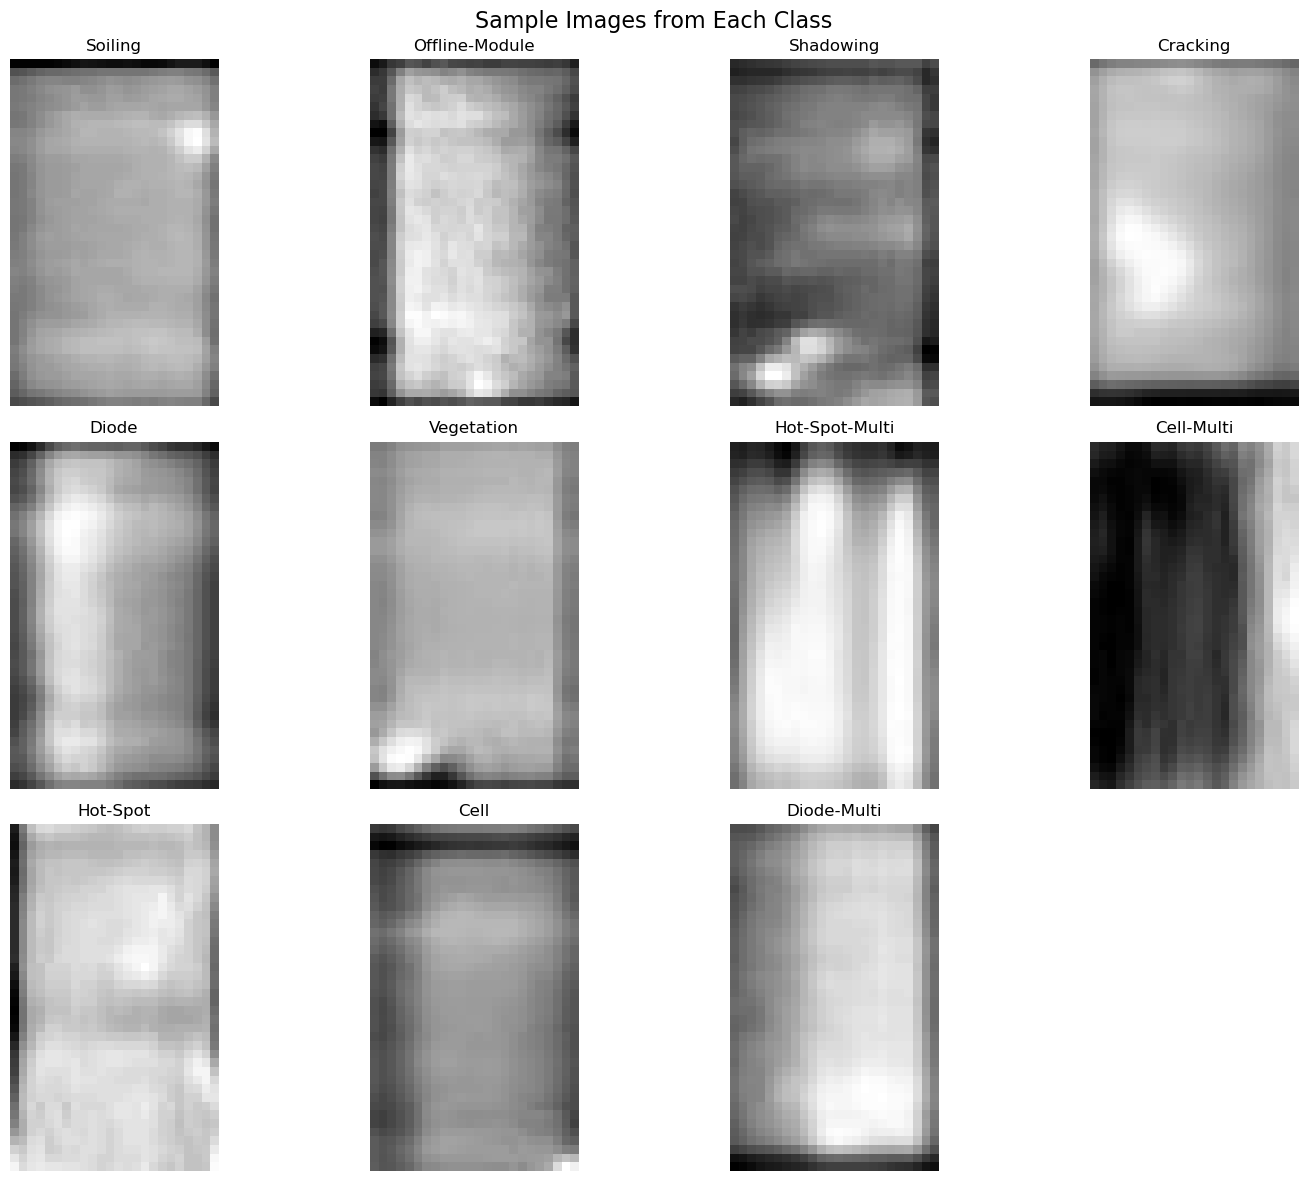

Number of training samples: 16520
Number of validation samples: 2066
Number of test samples: 2066
Number of classes: 11
Class mapping: {0: 'Cell', 1: 'Cell-Multi', 2: 'Cracking', 3: 'Diode', 4: 'Diode-Multi', 5: 'Hot-Spot', 6: 'Hot-Spot-Multi', 7: 'Offline-Module', 8: 'Shadowing', 9: 'Soiling', 10: 'Vegetation'}


In [11]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), label_number_to_name = load_normalize_and_split_dataset(
    "./InfraredSolarModules", 
    "./InfraredSolarModules/module_metadata.json"
)
# Plot sample images
plot_sample_images(X_train, y_train, label_number_to_name)

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)

# Print dataset information
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")
print(f"Number of classes: {len(label_number_to_name)}")
print(f"Class mapping: {label_number_to_name}")


In [12]:
def train(model: nn.Module, 
          loss_fn: nn.modules.loss._Loss, 
          optimizer: torch.optim.Optimizer, 
          train_loader: torch.utils.data.DataLoader, 
          epoch: int=0) -> List:
    model.train()
    train_loss = []
    total_batches = len(train_loader)
    log_interval = max(1, total_batches // 8)  # Log 8-10 times per epoch
    device = next(model.parameters()).device  # Get the device of the model

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)
        # Print shapes for debugging
        #print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        
        optimizer.zero_grad()
        outputs = model(images)
        # Print output shape for debugging
        #print(f"Batch {batch_idx}: Outputs shape: {outputs.shape}")
          
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        #if (batch_idx + 1) % log_interval == 0:
            #print(f'Epoch {epoch}: [{(batch_idx+1)*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

    return train_loss

In [13]:
def test(model, loss_fn, test_loader, epoch=0):
    device = next(model.parameters()).device
    model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            all_predictions.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    
    print(f"Test result on epoch {epoch}: total sample: {len(test_loader.dataset)}, Avg loss: {avg_loss:.3f}, Acc: {accuracy*100:.3f}%")
    
    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        "all_predictions": all_predictions,
        "all_labels": all_labels
    }

In [14]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_binary_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [15]:
class OurCNN(nn.Module):
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 1, 2688)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(2688, 960)
        self.fc3 = nn.Linear(960, num_classes)

    def forward(self, x):
        # Add print statement to check input shape
        #print(f"Input shape: {x.shape}")
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Add print statement to check shape before flattening
        #print(f"Shape before flattening: {x.shape}")
        x = x.view(-1, 128 * 2 * 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Add print statement to check output shape
        #print(f"Output shape: {x.shape}")
        return x

In [16]:
# Create the model and move it to the device
#print(len(label_number_to_name))
num_classes = len(label_number_to_name)
model = OurCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)
max_epoch = 40

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(max_epoch):
    train_loss = train(model, criterion, optimizer, train_loader, epoch)
    val_stat = test(model, criterion, val_loader, epoch)
    
    train_losses.append(sum(train_loss)/len(train_loss))
    val_losses.append(val_stat['loss'])
    val_accuracies.append(val_stat['accuracy'])
    
    print(f"Epoch {epoch+1}/{max_epoch}")
    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
    print()

Test result on epoch 0: total sample: 2066, Avg loss: 1.471, Acc: 49.564%
Epoch 1/40
Train Loss: 1.8771
Val Loss: 1.4708, Val Accuracy: 0.4956

Test result on epoch 1: total sample: 2066, Avg loss: 1.228, Acc: 55.712%
Epoch 2/40
Train Loss: 1.3745
Val Loss: 1.2279, Val Accuracy: 0.5571

Test result on epoch 2: total sample: 2066, Avg loss: 1.136, Acc: 60.407%
Epoch 3/40
Train Loss: 1.2225
Val Loss: 1.1361, Val Accuracy: 0.6041

Test result on epoch 3: total sample: 2066, Avg loss: 1.038, Acc: 62.149%
Epoch 4/40
Train Loss: 1.1264
Val Loss: 1.0384, Val Accuracy: 0.6215

Test result on epoch 4: total sample: 2066, Avg loss: 0.991, Acc: 63.408%
Epoch 5/40
Train Loss: 1.0539
Val Loss: 0.9910, Val Accuracy: 0.6341

Test result on epoch 5: total sample: 2066, Avg loss: 0.958, Acc: 65.440%
Epoch 6/40
Train Loss: 0.9861
Val Loss: 0.9580, Val Accuracy: 0.6544

Test result on epoch 6: total sample: 2066, Avg loss: 0.960, Acc: 65.586%
Epoch 7/40
Train Loss: 0.9330
Val Loss: 0.9600, Val Accuracy: 

In [17]:
# Final test
final_test_stat = test(model, criterion, test_loader, max_epoch)
print(f"Final Test Loss: {final_test_stat['loss']:.4f}, Test Accuracy: {final_test_stat['accuracy']:.4f}")

Test result on epoch 40: total sample: 2066, Avg loss: 0.942, Acc: 74.008%
Final Test Loss: 0.9422, Test Accuracy: 0.7401


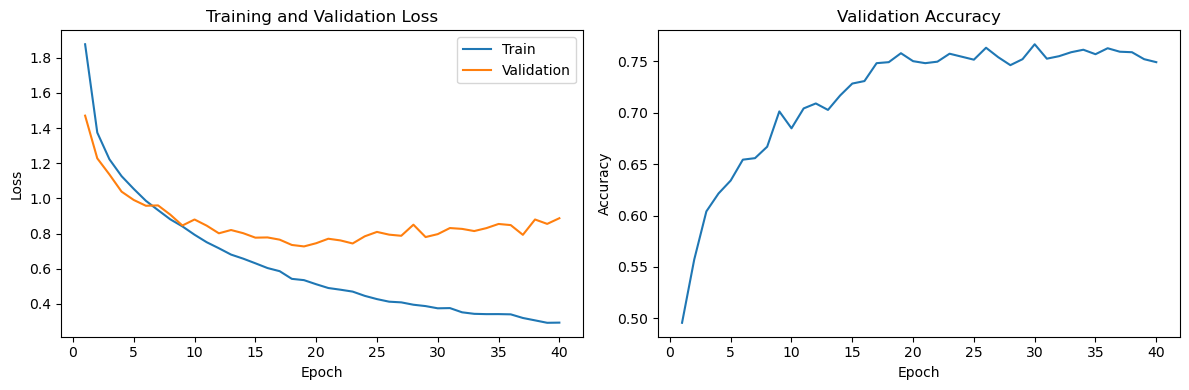

Final Test Accuracy: 0.7401


In [18]:

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch + 1), train_losses, label='Train')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, max_epoch + 1), val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

# Print final test accuracy
print(f"Final Test Accuracy: {final_test_stat['accuracy']:.4f}")